In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime as dt
import decouple
#from performance_stats import *
#from data_prep import *
#from loss_fcn import *
#from train_test import *
#from models import CNN_port
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load symbols
config = decouple.AutoConfig(' ')
path = config('PATH_MY_MAIN_DATA')
symbols = pd.read_csv(path+'/_data_symbols')
symbols = list(symbols.iloc[:, 1])
len(symbols)

468

In [18]:
def reduce_features(df, drop_columns):
    for col in df.columns:
        for dc in drop_columns:
            if dc in col:
                df = df.drop(col, axis=1)
    return df


def train_val_test(data, lookback=50, train_years=1, val_years=1, test_years=1):
    # drop NaNs
    data=data.dropna()
    
    # make train df
    year = data.index[-1].year
    x = data[dt(year+1,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_end_train = data.index.get_loc(x) + lookback
    x = data[dt(year+1+train_years,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_start_train = data.index.get_loc(x) + lookback
    
    df_train = data.iloc[index_start_train:index_end_train, :]
    
    # make validation df
    index_end_val = data.index.get_loc(df_train.index[0].strftime("%Y-%m-%d"))
    x = data[dt(year+1+train_years+val_years,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_start_val = data.index.get_loc(x) + lookback
    
    df_val = data.iloc[index_start_val:index_end_val, :]
    
    # make test df
    index_end_test = data.index.get_loc(df_val.index[0].strftime("%Y-%m-%d"))
    x = data[dt(year+1+train_years+val_years+test_years,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_start_test = data.index.get_loc(x) 
    
    df_test = data.iloc[index_start_test:index_end_test, :]
    
    return df_val.sort_index(), df_train.sort_index(), df_test.sort_index()


def get_targets(dataframe):
    targets = [dataframe[col] for col in dataframe.columns if 'return_next' in col]
    targets = pd.DataFrame(targets).transpose()
    return targets

def get_features(dataframe):
    features = [dataframe[col] for col in dataframe.columns if 'return_next' not in col]
    features = pd.DataFrame(features).transpose()
    return features
    
def standardize(dataframe):
    df_standardized = pd.DataFrame()
    for col in dataframe.columns:
        col_mean = dataframe[col].mean()
        col_std = dataframe[col].std()
        df_standardized[col] = (dataframe[col] - col_mean) / col_std
    return df_standardized

def unstandardize(df_stand, df_orig):
    if len(df_stand.columns) == len(df_orig.columns):
        df_un = pd.DataFrame()
        for i, col in enumerate(df_stand.columns):
            col_og = df_orig.columns[i]
            df_un[col] = df_stand[col] * df_orig[col_og].std() + df_orig[col_og].mean()
        return df_un
    else:
        print("Value Error: Dataframes must have same column lengths")
        

        

In [3]:
class TS_Dataset(Dataset):
    def __init__(self, dataframe,lookback=20):
        self.lookback = lookback
        self.X = torch.tensor(standardize(get_features(dataframe)).values).float()
        self.y = torch.tensor(standardize(get_targets(dataframe)).values).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        if i >= self.lookback - 1:
            i_start = i - self.lookback + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.lookback - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [30]:
def abs_softmax(x):
    """Returns weights with absolute values that sum to 1"""
    means = torch.mean(x, dim=1, keepdim=True)
    x_exp = torch.exp(x.abs()- means)
    x_exp_sum = torch.sum(x_exp,  dim=1, keepdims=True)
    
    return torch.sign(x)*x_exp/x_exp_sum


def sharpe_loss(weights, returns):
    """Calculate Sharpe ratio given by model weights"""
    portfolio_returns = weights.multiply(returns).sum(dim=1)
    sharpe = portfolio_returns.mean() / portfolio_returns.std()
    return -sharpe

def return_loss(weights, returns):
    portfolio_returns = weights.multiply(returns).sum(dim=1)
    return - portfolio_returns
# still uncertain if this is specified correctly or not due to 
# best way to do i

In [9]:
class FCN_port(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20 * 2814, 1000)
        self.fc2 = nn.Linear(1000, 468)

        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        x = abs_softmax(self.fc2(x))
        return x
    

In [10]:
class CNN_port(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 2)
        self.fc1 = nn.Linear(20 * 78 * 2, 13)
    
    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = abs_softmax(self.fc1(x))
        

In [11]:
#  code from crosstab article
class LSTM_port(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=468)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.
        out = torch.flatten(out, 1)
        
        out = abs_softmax(out)
        return out


In [12]:
#  code from crosstab article
class GRU_port(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.gru = nn.GRU(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=468)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        
        _, hn = self.gru(x, h0)
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.
        out = torch.flatten(out, 1)
        
        out = abs_softmax(out)
        return out


In [14]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()
    

    avg_loss = total_loss / num_batches
    return avg_loss


def early_stop(losses, tolerance=5):
    min_loss_idx = losses.index(min(losses))
    since_new_min = len(losses) - 1 - min_loss_idx
    if since_new_min >= tolerance:
        return True
    
def plot_losses(train_losses, val_losses):
    x = range(len(train_losses))
    plt.plot(x, train_losses, label='Train Loss')
    plt.plot(x, val_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.show()

def plot_returns(p_return, bm_return, returns=True):
    x = range(len(p_return))
    if returns:
        plt.plot(x, p_return, label='Portfolio Return')
        plt.plot(x, bm_return, label='Benchmark Return')
    else:
        plt.plot(x, p_return, label='Portfolio Sharpe')
        plt.plot(x, bm_return, label='Benchmark Sharpe')
    plt.legend(loc='upper left')
    plt.show()


In [15]:
# define functions for obtaining/visualizing predictions
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

def get_pred_df_sharpe(df_train, df_test, model, batch_size,
                       lookback, tickers,num_assets=468, test_only=False):
    """Create dataframe with actual and un-normalized predicted return values """
    
    train_dataset = TS_Dataset(df_train, lookback=lookback)
    test_dataset = TS_Dataset(df_test, lookback=lookback)
    test_loader = DataLoader(test_dataset,
                        batch_size,
                        shuffle=False)
    
    train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    y_hat = '_port_weight'
    targets = get_targets(df_train)
    column_names = [col[12:] + y_hat for col in targets.columns]
    
    df_out_train = pd.DataFrame(predict(train_eval_loader, model).numpy(),
                         columns=column_names,
                         index=df_train.index)


    df_out_train = targets.join(df_out_train)
    
    df_out_test = pd.DataFrame(predict(test_loader, model).numpy(),
                              columns=column_names,
                              index=df_test.index)

    df_out_test = get_targets(df_test).join(df_out_test)
    
    df_out = pd.concat((df_out_train, df_out_test))

    df_out['return_next_portfolio'] = (df_out.iloc[:, num_assets:].values * df_out.iloc[:, :num_assets].values).sum(axis=1)
    df_out['return_portfolio'] = df_out['return_next_portfolio'].shift(1)
    
    # add benchmark column
    weight = 1 / num_assets
    weights = np.repeat(weight, num_assets)    
    df_out['return_next_benchmark'] = (df_out.iloc[:, :num_assets].values * weights).sum(axis=1)
    df_out['return_benchmark'] = df_out['return_next_benchmark'].shift(1)
    
    # add costs
    df_out = turnover_cost(df_out, tickers, bps=1)
    
    if test_only:
        year = df_test.index[0].year + 1
        date = str(year) + '-01-01'
        return df_out[df_out.index >= date]
    else:
        return df_out




In [16]:
def total_return(return_col, start = True, stop = True, annualized=True):
    if start:
        start = return_col.index[0]
    if stop:
        stop = return_col.index[-1]
    if start > stop:
        print("Index Error: Start given is after Stop given")
    else:
        return_col = return_col[(return_col.index >= start) & (return_col.index <= stop)]
        return_col = return_col + 1
        ttl_return = 1
        for i in range(len(return_col)):
                ttl_return *= return_col[i]
        days  = (pd.to_datetime(stop) - pd.to_datetime(start)).days
        years = days / 365
        annualized_return = ttl_return ** (1 / years) - 1
        ttl_return -= 1
        if annualized == True:
            return annualized_return
        else:
            return ttl_return
        

def return_std(return_col, start = True, stop = True, annualized=True):
    if start:
        start = return_col.index[0]
    if stop:
        stop = return_col.index[-1]    
    if start > stop:
        print("Index Error: Start given is after Stop given")
    else:
        return_col = return_col[(return_col.index >= start) & (return_col.index <= stop)]
        if annualized:
            return return_col.std() * np.sqrt(250)
        else:
            return return_col.std()

def sharpe_ratio(return_col, start = True, stop = True):
    if start:
        start = return_col.index[0]
    if stop:
        stop = return_col.index[-1]
    ann_return = total_return(return_col, start, stop, annualized=True)
    ann_std = return_std(return_col, start, stop, annualized=True)
    
    return ann_return / ann_std
    
def turnover_cost(df_pred, tickers, bps=1):
    """Calculate costs from asset turnover"""
    df_pred = df_pred.sort_index(ascending=True)
    port_value = 1 # assume portfolio value = 1 after first time period
    costs = []
    cost_returns = []
    for i in range(df_pred.shape[0] - 1):
        cost_ticker = []
        for j, ticker in enumerate(tickers):
            asset_value_0 = port_value * df_pred[str(tickers[j]) + '_port_weight'][i]
            asset_value_1 = asset_value_0 * (1 + df_pred['return_next_' + str(tickers[j])][i])
            port_value_next = port_value * (1+df_pred['return_next_portfolio'][i])
            asset_value_next =  port_value_next * df_pred[str(tickers[j]) + '_port_weight'][i+1]        
            val_change = np.abs((asset_value_next - asset_value_1))
            cost = val_change * bps / 10000 * -1
            cost_ticker.append(cost)
        cost_sum = np.sum(cost_ticker)
        costs.append(cost_sum)
        cost_return = cost_sum / port_value
        cost_returns.append(cost_return)
        port_value *= (1 + df_pred['return_next_portfolio'][i] + cost_return)
    cost_returns.append(0)
    df_pred['cost_return_next'] = cost_returns
    df_pred['cost_return'] = df_pred['cost_return_next'].shift(1)
    df_pred['total_portfolio_return'] = df_pred['cost_return'] + df_pred['return_portfolio']
    return df_pred


In [33]:
# load data
config = decouple.AutoConfig(' ')
path = config('PATH_MY_MAIN_DATA')
data = pd.read_csv(path+'/_data_set_model', index_col='date', parse_dates=True)
pd.options.display.max_columns = None
data = reduce_features(data, ['adjopen', 'adjhigh', 'adjlow', 'adj_range', 'volume_dollars'])


In [38]:
df_train

return_A  norm_adjclose_A  return_next_A  return_AAL  \
date                                                               
2011-12-02 -0.028836        83.545455       0.008095   -0.020661   
2011-12-05  0.008095        84.227273      -0.002163    0.054687   
2011-12-06 -0.002163        84.045455      -0.008729    0.024762   
2011-12-07 -0.008729        83.318182      -0.065078    0.060823   
2011-12-08 -0.065078        78.227273       0.025757   -0.046816   
...              ...              ...            ...         ...   
2014-11-25  0.010770       138.201498       0.000702    0.021291   
2014-11-26  0.000702       138.298572       0.000000    0.018234   
2014-11-28  0.000000       138.298572      -0.027651    0.073357   
2014-12-01 -0.027651       134.577389       0.009290   -0.013576   
2014-12-02  0.009290       135.839355       0.005920   -0.000418   

            norm_adjclose_AAL  return_next_AAL  return_AAP  norm_adjclose_AAP  \
date                                                                            
2011-12-02          25.077720         0.054687    0.004489         513.516866   
2011-12-05          26.528497         0.024762    0.012300         519.911661   
2011-12-06          27.202073         0.060823    0.002425         521.175748   
2011-12-07          28.963731        -0.046816   -0.001286         520.506525   
2011-12-08          27.668394         0.049822   -0.001431         519.762944   
...                       ...              ...         ...                ...   
2014-11-25         229.914391         0.018234   -0.000894        1090.544522   
2014-11-26         234.184602         0.073357    0.001784        1092.493931   
2014-11-28         252.723566        -0.013576    0.009315        1102.765818   
2014-12-01         249.338642        -0.000418   -0.000068        1102.690841   
2014-12-02         249.234491         0.007877    0.009496        1113.262637   

            return_next_AAP  return_AAPL  norm_adjclose_AAPL  \
date                                                           
2011-12-02         0.012300     0.004542         2008.245298   
2011-12-05         0.002425     0.008422         2025.302757   
2011-12-06        -0.001286    -0.005269         2014.686936   
2011-12-07        -0.001431    -0.004780         2005.101778   
2011-12-08         0.005407     0.004019         2013.192476   
...                     ...          ...                 ...   
2014-11-25         0.001784    -0.008716         4479.911097   
2014-11-26         0.009315     0.011765         4533.243372   
2014-11-28        -0.000068    -0.000589         4530.576759   
2014-12-01         0.009496    -0.033545         4383.532058   
2014-12-02         0.023415    -0.003838         4366.770485   

            return_next_AAPL  return_ABC  norm_adjclose_ABC  return_next_ABC  \
date                                                                           
2011-12-02          0.008422   -0.006215        1181.336376        -0.010926   
2011-12-05         -0.005269   -0.010926        1168.568623        -0.004665   
2011-12-06         -0.004780   -0.004665        1163.142328         0.004099   
2011-12-07          0.004019    0.004099        1167.930235        -0.008545   
2011-12-08          0.007520   -0.008545        1158.035227         0.002475   
...                      ...         ...                ...              ...   
2014-11-25          0.011765    0.003100        3013.866924        -0.002553   
2014-11-26         -0.000589   -0.002553        3006.192108         0.010544   
2014-11-28         -0.033545    0.010544        3038.226123        -0.002312   
2014-12-01         -0.003838   -0.002312        3031.218683         0.013038   
2014-12-02          0.011214    0.013038        3071.261202        -0.000544   

            return_ABT  norm_adjclose_ABT  return_next_ABT  return_ACGL  \
date                                                                      
2011-12-02   -0.006833         205.076974        

In [37]:
# load datasets
torch.manual_seed(55)

batch_size = 32
lookback = 20

df_val, df_train, df_test = train_val_test(data, lookback, train_years=3) 

train_dataset = TS_Dataset(df_train, lookback=lookback)
val_dataset = TS_Dataset(df_val, lookback=lookback)
test_dataset = TS_Dataset(df_test, lookback=lookback)

# Should I shuffle data for models with memory? RNN order matters
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)



Features shape: torch.Size([32, 20, 936])
Target shape: torch.Size([32, 468])


In [ ]:
# use a 1d layer for now
class CNN_port(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=2, padding=0)
        self.fc1 = nn.Linear(3118, 468)
    
    def forward(self, x):
        x = x.reshape([32, 1, 20*78])
        x = F.tanh(self.conv1(x))
        x = torch.flatten(x, 1)
        x = abs_softmax(self.fc1(x))
        

In [ ]:
model= CNN_port()
model.input_shape()

In [ ]:

model= CNN_port()
output = []
for X, y  in  train_loader:
    X = X.reshape([32, 1, 20*78])
    output.append(model(X))
    

In [ ]:
list(range(3, 10))


In [117]:
#  code from crosstab article
class LSTM_port(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=468)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.
        out = torch.flatten(out, 1)
        
        out = abs_softmax(out)
        return out


In [ ]:
model = LSTM_port(num_sensors=get_features(df_train).shape[1], hidden_units=num_hidden_units)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)



In [118]:
#hyperparam testing-fcn
# best lr: 0.00005
# best num epochs: 200
#hyperparam test lstm
# best  lr: 0.0001
#   best num  epochs: 100
# best hidden units: 1024
lr = 0.0001
num_hidden_units = 1024
#model=FCN_port()
#epochs = [50, 100, 150, 200, 250]



min_val_loss = []
time = []
    
model = LSTM_port(num_sensors=get_features(df_train).shape[1], hidden_units=num_hidden_units)
loss_function = sharpe_loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []
t0 = dt.now()
for epoch in range(100):
    t00 = dt.now()
    print(f"Epoch {epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    val_loss = test_model(val_loader, model, loss_function)
    val_losses.append(val_loss)
    t01 = dt.now()
    T1 = (t01 - t00).total_seconds()
    print('Train loss: {}'.format(train_loss))
    print('Validation loss: {}'.format(val_loss))
    print('Time to train: {} seconds'.format(T1))
    print()
        
    if early_stop(val_losses, tolerance=100):
        print('Early Stop Triggered')
        break
val_losses.sort()        
x = val_losses
x = np.mean(x[:5])
min_val_loss.append(x)
t1 = dt.now()
T = (t1 - t0).total_seconds()
time.append(T)
print('Time to train: {} seconds'.format(T))

print('Total time: {} seconds'.format(np.sum(time)))







Epoch 0
---------
Train loss: 0.04462649292933444
Validation loss: 0.17492347583174706
Time to train: 11.917772 seconds

Epoch 1
---------
Train loss: -0.2062893710875263
Validation loss: -0.10465076728723943
Time to train: 11.650402 seconds

Epoch 2
---------
Train loss: -0.6337406747043133
Validation loss: -0.12628316425252706
Time to train: 11.651412 seconds

Epoch 3
---------
Train loss: -1.056865715732177
Validation loss: -0.07790962886065245
Time to train: 11.659309 seconds

Epoch 4
---------
Train loss: -1.2164751812815666
Validation loss: -0.17669271118938923
Time to train: 11.695754 seconds

Epoch 5
---------
Train loss: -1.435016247133414
Validation loss: -0.12268442753702402
Time to train: 11.643435 seconds

Epoch 6
---------
Train loss: -1.8010289842883747
Validation loss: -0.08808545267675072
Time to train: 11.663577 seconds

Epoch 7
---------
Train loss: -1.6796712850530942
Validation loss: -0.11392056848853827
Time to train: 11.57187 seconds

Epoch 8
---------
Train loss

Train loss: -5.561864624420802
Validation loss: -0.07420185473165475
Time to train: 11.671197 seconds

Epoch 69
---------
Train loss: -6.383311986923218
Validation loss: -0.09558283328078687
Time to train: 11.674441 seconds

Epoch 70
---------
Train loss: -5.3475499252478285
Validation loss: -0.08394842268899083
Time to train: 11.55561 seconds

Epoch 71
---------
Train loss: -6.286043395598729
Validation loss: -0.08934191637672484
Time to train: 11.62582 seconds

Epoch 72
---------
Train loss: -5.89285949865977
Validation loss: -0.11686835251748562
Time to train: 11.633439 seconds

Epoch 73
---------
Train loss: -5.979005446036656
Validation loss: -0.11833947896957397
Time to train: 11.619015 seconds

Epoch 74
---------
Train loss: -5.998186965783437
Validation loss: -0.1041184738278389
Time to train: 11.645678 seconds

Epoch 75
---------
Train loss: -6.765826682249705
Validation loss: -0.09635934326797724
Time to train: 11.86443 seconds

Epoch 76
---------
Train loss: -6.4983578523000

In [148]:
# Train and Validate model
learning_rate = 0.00001
#model=FCN_port()
model = LSTM_port(num_sensors=get_features(df_train).shape[1], hidden_units=num_hidden_units)
num_hidden_units = 1024
#model = GRU_port(num_sensors=get_features(df_train).shape[1], hidden_units=num_hidden_units)
loss_function = sharpe_loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Untrained test\n--------")
test_model(val_loader, model, loss_function)
print()

# loop through different time periods
df_predictions = pd.DataFrame()
test_losses = []
benchmark_returns = []
benchmark_sharpe = []
portfolio_returns = []
portfolio_sharpe = []
for i in range(3,10):
    t0 = dt.now()
    df_val, df_train, df_test = train_val_test(data, lookback, train_years=i) 

    train_dataset = TS_Dataset(df_train, lookback=lookback)
    val_dataset = TS_Dataset(df_val, lookback=lookback)
    test_dataset = TS_Dataset(df_test, lookback=lookback)

    # Should I shuffle data for models with memory? RNN order matters
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=False)

    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)


    train_losses = []
    val_losses = []
    for epoch in range(100):
        print(f"Epoch {epoch}\n---------")
        train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
        train_losses.append(train_loss)
        val_loss = test_model(val_loader, model, loss_function)
        val_losses.append(val_loss)
    
        if early_stop(val_losses, tolerance=100):
            print('Early Stop Triggered')
            break
    
        print('Train loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(val_loss))
        print()
    test_loss = test_model(test_loader, model, loss_function)
    test_losses.append(test_loss)
    
    df_int = get_pred_df_sharpe(df_train,
                                df_test,
                                model=model,
                                batch_size=batch_size,
                                lookback=lookback,
                                tickers=symbols,
                                test_only=True)
    df_predictions = pd.concat([df_predictions, df_int]).sort_index(ascending=True)
    
    bm_r = total_return(df_int['return_benchmark'])
    bm_s = sharpe_ratio(df_int['return_benchmark'])
    p_r = total_return(df_int['return_portfolio'])
    p_s = sharpe_ratio(df_int['return_portfolio'])
    
    benchmark_returns.append(bm_r)
    benchmark_sharpe.append(bm_s)
    portfolio_returns.append(p_r)
    portfolio_sharpe.append(p_s)
    
    t1 = dt.now()
    T = (t1 - t0).total_seconds()
    print()
    print('Test loss: {} Portfolio return: {}, Portfolio Sharpe: {}'.format(test_loss, p_r, p_s))
    print('Benchmark return: {}, Benchmark Sharpe: {}'.format(bm_r, bm_s))
    
    print('Total seconds to train:  {}'.format(T))
   



Untrained test
--------

Epoch 0
---------
Train loss: -0.04535161915312832
Validation loss: -0.1261931495682802

Epoch 1
---------
Train loss: -0.3293778874600927
Validation loss: -0.10878608044004068

Epoch 2
---------
Train loss: -0.461186614818871
Validation loss: -0.168490071548149

Epoch 3
---------
Train loss: -0.5458289987097183
Validation loss: -0.1336333134677261

Epoch 4
---------
Train loss: -0.8949763514101505
Validation loss: -0.09566833381541073

Epoch 5
---------
Train loss: -0.727957638601462
Validation loss: -0.14149021776393056

Epoch 6
---------
Train loss: -1.0872158805529277
Validation loss: -0.13798952056095004

Epoch 7
---------
Train loss: -1.1616838611662388
Validation loss: -0.1855358718894422

Epoch 8
---------
Train loss: -1.102622094253699
Validation loss: -0.13577082753181458

Epoch 9
---------
Train loss: -1.4247977832953136
Validation loss: -0.17775153135880828

Epoch 10
---------
Train loss: -1.3167645980914433
Validation loss: -0.16135215014219284

Ep

Train loss: -4.010251437624295
Validation loss: -0.19604542572051287

Epoch 93
---------
Train loss: -3.74701506147782
Validation loss: -0.17703363951295614

Epoch 94
---------
Train loss: -4.4213323046763735
Validation loss: -0.2016403330489993

Epoch 95
---------
Train loss: -4.4604835112889605
Validation loss: -0.1847746903076768

Epoch 96
---------
Train loss: -5.440945004423459
Validation loss: -0.20920609193854034

Epoch 97
---------
Train loss: -3.793958177169164
Validation loss: -0.2332311305217445

Epoch 98
---------
Train loss: -6.65202692647775
Validation loss: -0.2276022033765912

Epoch 99
---------
Train loss: -4.770756895343463
Validation loss: -0.20449605025351048


Test loss: -0.10597682371735573 Portfolio return: 0.025523178128780133, Portfolio Sharpe: 1.9043864917940183
Benchmark return: 0.10040765260478324, Benchmark Sharpe: 0.7170028965225378
Total seconds to train:  1193.544748
Epoch 0
---------
Train loss: -1.8467753394506872
Validation loss: -0.1997837353264913



Train loss: -4.774160197935998
Validation loss: -0.1725701680406928

Epoch 83
---------
Train loss: -3.1479263762012124
Validation loss: -0.1562893958762288

Epoch 84
---------
Train loss: -5.031567463185638
Validation loss: -0.15354399336501956

Epoch 85
---------
Train loss: -4.771273557562381
Validation loss: -0.16294649243354797

Epoch 86
---------
Train loss: -5.4802130199968815
Validation loss: -0.18451910791918635

Epoch 87
---------
Train loss: -5.66687935590744
Validation loss: -0.16626388393342495

Epoch 88
---------
Train loss: -3.938257764559239
Validation loss: -0.18581884435843676

Epoch 89
---------
Train loss: -5.597855408210307
Validation loss: -0.17311851307749748

Epoch 90
---------
Train loss: -5.855759097263217
Validation loss: -0.15654829237610102

Epoch 91
---------
Train loss: -4.420159169472754
Validation loss: -0.16550875478424132

Epoch 92
---------
Train loss: -6.409343236126006
Validation loss: -0.16779949990450405

Epoch 93
---------
Train loss: -4.9061009

Train loss: -4.320667173713446
Validation loss: -0.04328894708305597

Epoch 73
---------
Train loss: -5.445854917168617
Validation loss: -0.052846994367428124

Epoch 74
---------
Train loss: -4.570824503153562
Validation loss: -0.02491798542905599

Epoch 75
---------
Train loss: -4.574623301625252
Validation loss: -0.028921371675096452

Epoch 76
---------
Train loss: -5.633334641903639
Validation loss: -0.04826283920556307

Epoch 77
---------
Train loss: -4.2185961827635765
Validation loss: -0.04734390648081899

Epoch 78
---------
Train loss: -5.27726070433855
Validation loss: -0.04056346323341131

Epoch 79
---------
Train loss: -5.057187485694885
Validation loss: -0.03991639520972967

Epoch 80
---------
Train loss: -4.845794953405857
Validation loss: -0.03168349154293537

Epoch 81
---------
Train loss: -5.696444994956255
Validation loss: -0.04053926840424538

Epoch 82
---------
Train loss: -4.24790481030941
Validation loss: -0.04723888076841831

Epoch 83
---------
Train loss: -5.41330

KeyboardInterrupt: 

In [ ]:
plot_losses(train_losses, val_losses)

In [22]:
def get_targets(dataframe):
    targets = [dataframe[col] for col in dataframe.columns if 'return_next' in col]
    targets = pd.DataFrame(targets).transpose()
    return targets

def get_attn_targs(dataframe):
    targs = [dataframe[col] for col in dataframe.columns if ('return_' in col) & ('return_next' not in col)]
    targs = pd.DataFrame(targs).transpose()
    return targs

class TS_Dataset_attn(Dataset):
    def __init__(self, dataframe,lookback=50):
        self.lookback = lookback
        self.X = torch.tensor(standardize(get_features(dataframe)).values).float()
        self.y = torch.tensor(standardize(get_targets(dataframe)).values).float()
        self.tgt = torch.tensor(standardize(get_attn_targs(dataframe)).values).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        if i >= self.lookback - 1:
            i_start = i - self.lookback + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.lookback - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i], self.tgt[i]
    

In [23]:
class PositionalEncoder(nn.Module):
    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=50, 
        d_model: int=512,
        batch_first: bool=True
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """
        super().__init__()
        self.d_model = d_model    
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        if  batch_first:
            self.x_dim = 1 
            position = torch.arange(max_seq_len).unsqueeze(1) # shape:  (20, 1)
            div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) #shape 256
            pe = torch.zeros(1, max_seq_len, d_model) # shape (20, 1, 512)
            pe[0, :, 0::2] = torch.sin(position * div_term)
            pe[0, :, 1::2] = torch.cos(position * div_term)
            self.register_buffer('pe', pe)
            
        else:
            self.x_dim = 0
            # copy pasted from PyTorch tutorial
            position = torch.arange(max_seq_len).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
            pe = torch.zeros(max_seq_len, 1, d_model)  # shape (20, 1, 512)
            pe[:, 0, 0::2] = torch.sin(position * div_term) #shape (20, 256)
            pe[:, 0, 1::2] = torch.cos(position * div_term) #shape (20, 256)
            self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
                [enc_seq_len, batch_size, dim_val]
            """

        x = x + self.pe[:x.size(self.x_dim)] # x shape is (32, 20, 512)

        return self.dropout(x)
    
class Transformer_port(nn.Module):
    def __init__(self,
        input_size: int,
        dec_seq_len: int,
        batch_first: True,
        out_seq_len: int=58,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=468
        ):
        
        super().__init__()
        self.dec_seq_len = dec_seq_len
        self.encoder_input_layer = nn.Linear(
            in_features=input_size,
            out_features=dim_val)

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features, # the number of features you want to predict
            out_features=dim_val) 

        self.linear = nn.Linear(
            in_features=dim_val,
            out_features=num_predicted_features)
        
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers,
            norm=None)
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first)
        
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers,
            norm=None)
        
    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        
        src = self.encoder_input_layer(src) 
        src = self.positional_encoding_layer(src)
        src = self.encoder(src=src) # src shape: [batch_size, enc_seq_len, dim_val]
        
        decoder_output = self.decoder_input_layer(tgt) # outputs shpe (32, 512)
        decoder_output =  decoder_output.reshape(decoder_output.shape[0], 1, decoder_output.shape[1])
        
        decoder_output = self.decoder(
            tgt=decoder_output, #(32, 1, 512)
            memory=src, #(32, 20, 512)
            tgt_mask=tgt_mask, #(1, 1)
            memory_mask=src_mask) #(1, 20)
        
        decoder_output = self.linear(decoder_output)
        decoder_output = decoder_output.reshape(decoder_output.shape[0], decoder_output.shape[2])
        decoder_output = abs_softmax(decoder_output)
        
        return decoder_output

In [24]:
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

def train_model_attn(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y, trg in data_loader:
        enc_seq_len = X.shape[1]

        # Output length
        output_sequence_length = 1
        
        tgt_mask = generate_square_subsequent_mask(
        dim1=output_sequence_length,
        dim2=output_sequence_length)
        
        src_mask = generate_square_subsequent_mask(
        dim1=output_sequence_length,
        dim2=enc_seq_len)
        
        output = model(
            src=X,
            tgt=trg,
            src_mask=src_mask,
            tgt_mask=tgt_mask)
        
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model_attn(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y, trg in data_loader:
            enc_seq_len = X.shape[1]

            # Output length
            output_sequence_length = 1
        
            tgt_mask = generate_square_subsequent_mask(
            dim1=output_sequence_length,
            dim2=output_sequence_length)
        
            src_mask = generate_square_subsequent_mask(
            dim1=output_sequence_length,
            dim2=enc_seq_len)
        
            output = model(
                src=X,
                tgt=trg,
                src_mask=src_mask,
                tgt_mask=tgt_mask)
            
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    return avg_loss



In [25]:
def predict_attn(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _, trg in data_loader:
            enc_seq_len = X.shape[1]
            # Output length
            output_sequence_length = 1
            
            tgt_mask = generate_square_subsequent_mask(
            dim1=output_sequence_length,
            dim2=output_sequence_length)
        
            src_mask = generate_square_subsequent_mask(
            dim1=output_sequence_length,
            dim2=enc_seq_len)
        
            y_star = model(
                src=X,
                tgt=trg,
                src_mask=src_mask,
                tgt_mask=tgt_mask)
            
            output = torch.cat((output, y_star), 0)
    
    return output


def get_pred_df_sharpe_attn(df_train, df_test, model, batch_size,
                       lookback, tickers, num_assets=468, test_only=False):
    """Create dataframe with actual and un-normalized predicted return values """
    
    train_dataset = TS_Dataset_attn(df_train, lookback=lookback)
    test_dataset = TS_Dataset_attn(df_test, lookback=lookback)
    test_loader = DataLoader(test_dataset,
                        batch_size,
                        shuffle=False)
    
    train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    y_hat = '_port_weight'
    targets = get_targets(df_train)
    column_names = [col[(12):] + y_hat for col in targets.columns]
    
    df_out_train = pd.DataFrame(predict_attn(train_eval_loader, model).numpy(),
                         columns=column_names,
                         index=df_train.index)


    df_out_train = targets.join(df_out_train)
    
    df_out_test = pd.DataFrame(predict_attn(test_loader, model).numpy(),
                              columns=column_names,
                              index=df_test.index)

    df_out_test = get_targets(df_test).join(df_out_test)
    
    df_out = pd.concat((df_out_train, df_out_test))

    df_out['return_next_portfolio'] = (df_out.iloc[:, num_assets:].values * df_out.iloc[:, :num_assets].values).sum(axis=1)
    df_out['return_portfolio'] = df_out['return_next_portfolio'].shift(1)
    
    # add benchmark column
    weight = 1 / num_assets
    weights = np.repeat(weight, num_assets)    
    df_out['return_next_benchmark'] = (df_out.iloc[:, :num_assets].values * weights).sum(axis=1)
    df_out['return_benchmark'] = df_out['return_next_benchmark'].shift(1)
    
    # add costs
    df_out = turnover_cost(df_out, tickers, bps=1)
    
    if test_only:
        year = df_test.index[0].year + 1
        date = str(year) + '-01-01'
        return df_out[df_out.index >= date]
    else:
        return df_out


,return_next_A,return_next_AAL,return_next_AAP,return_next_AAPL,return_next_ABC,return_next_ABT,return_next_ACGL,return_next_ACN,return_next_ADBE,return_next_ADI,return_next_ADM,return_next_ADP,return_next_ADSK,return_next_AEE,return_next_AEP,return_next_AES,return_next_AFL,return_next_AGG,return_next_AIG,return_next_AIZ,return_next_AJG,return_next_AKAM,return_next_ALB,return_next_ALGN,return_next_ALK,return_next_ALL,return_next_AMAT,return_next_AMD,return_next_AME,return_next_AMGN,return_next_AMP,return_next_AMT,return_next_AMZN,return_next_ANSS,return_next_AON,return_next_AOS,return_next_APA,return_next_APD,return_next_APH,return_next_ARE,return_next_ASML,return_next_ATO,return_next_ATVI,return_next_AVB,return_next_AVY,return_next_AXP,return_next_AZN,return_next_AZO,return_next_BA,return_next_BAC,return_next_BALL,return_next_BAX,return_next_BBWI,return_next_BBY,return_next_BDX,return_next_BEN,return_next_BIIB,return_next_BIO,return_next_BK,return_next_BKNG,return_next_BLK,return_next_BMY,return_next_BRO,return_next_BSX,return_next_BWA,return_next_BXP,return_next_C,return_next_CAG,return_next_CAH,return_next_CAT,return_next_CB,return_next_CBRE,return_next_CCI,return_next_CCL,return_next_CDNS,return_next_CE,return_next_CF,return_next_CHD,return_next_CHRW,return_next_CI,return_next_CINF,return_next_CL,return_next_CLX,return_next_CMA,return_next_CMCSA,return_next_CME,return_next_CMI,return_next_CMS,return_next_CNC,return_next_CNP,return_next_COF,return_next_COO,return_next_COP,return_next_COST,return_next_CPB,return_next_CPRT,return_next_CPT,return_next_CRL,return_next_CRM,return_next_CSCO,return_next_CSGP,return_next_CSX,return_next_CTAS,return_next_CTRA,return_next_CTSH,return_next_CVS,return_next_CVX,return_next_D,return_next_DD,return_next_DE,return_next_DGX,return_next_DHI,return_next_DHR,return_next_DIA,return_next_DIS,return_next_DISH,return_next_DLR,return_next_DLTR,return_next_DOV,return_next_DPZ,return_next_DRI,return_next_DTE,return_next_DUK,return_next_DVA,return_next_DVN,return_next_DVY,return_next_DXCM,return_next_EA,return_next_EBAY,return_next_ECL,return_next_ED,return_next_EEM,return_next_EFA,return_next_EFV,return_next_EFX,return_next_EIX,return_next_EL,return_next_ELV,return_next_EMN,return_next_EMR,return_next_EOG,return_next_EQIX,return_next_EQR,return_next_EQT,return_next_ES,return_next_ESS,return_next_ETN,return_next_ETR,return_next_EW,return_next_EXC,return_next_EXPD,return_next_EXPE,return_next_EXR,return_next_F,return_next_FAST,return_next_FCX,return_next_FDS,return_next_FDX,return_next_FE,return_next_FFIV,return_next_FIS,return_next_FISV,return_next_FITB,return_next_FMC,return_next_FRT,return_next_GD,return_next_GE,return_next_GEN,return_next_GILD,return_next_GIS,return_next_GL,return_next_GLD,return_next_GLW,return_next_GOOGL,return_next_GPC,return_next_GPN,return_next_GRMN,return_next_GS,return_next_GWW,return_next_HAL,return_next_HAS,return_next_HBAN,return_next_HD,return_next_HES,return_next_HIG,return_next_HOLX,return_next_HON,return_next_HPQ,return_next_HRL,return_next_HSIC,return_next_HST,return_next_HSY,return_next_HUM,return_next_HWM,return_next_IAU,return_next_IBM,return_next_ICE,return_next_ICF,return_next_IDXX,return_next_IEF,return_next_IEX,return_next_IFF,return_next_IJH,return_next_IJR,return_next_ILMN,return_next_INCY,return_next_INTC,return_next_INTU,return_next_IP,return_next_IPG,return_next_IRM,return_next_ISRG,return_next_IT,return_next_ITOT,return_next_ITW,return_next_IVE,return_next_IVV,return_next_IVW,return_next_IVZ,return_next_IWB,return_next_IWD,return_next_IWF,return_next_IWM,return_next_IWR,return_next_IYR,return_next_J,return_next_JBHT,return_next_JCI,return_next_JKHY,return_next_JNJ,return_next_JNPR,return_next_JPM,return_next_K,return_next_KEY,return_next_KLAC,return_next_KMB,return_next_KMX,return_next_KO,return_next_KR,return_next_L,return_next_LEN,return_next_LH,return_next_LHX,return_next_LKQ,return_next_LLY,return_next_LMT,return_next_LNC,return_next_LNT,return_next_

In [28]:
# load datasets
torch.manual_seed(55)

batch_size = 32
lookback = 50

df_val, df_train, df_test = train_val_test(data, lookback, train_years=3) 

train_dataset = TS_Dataset_attn(df_train, lookback=lookback)
val_dataset = TS_Dataset_attn(df_val, lookback=lookback)
test_dataset = TS_Dataset_attn(df_test, lookback=lookback)

# Should I shuffle data for models with memory? RNN order matters
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

X, y, tgt = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Tgt shape:", tgt.shape)


Features shape: torch.Size([32, 50, 936])
Target shape: torch.Size([32, 468])
Tgt shape: torch.Size([32, 468])


In [174]:
## Model parameters
dim_val = 256 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 1872 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 50 # length of input given to decoder. Can have any integer value.
enc_seq_len = 50 # length of input given to encoder. Can have any integer value.
output_sequence_length = 1 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

batch_size = 32

model = Transformer_port(
    batch_first=True,
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads)

loss_function = sharpe_loss
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

min_val_loss = []
time = []

train_losses = []
val_losses = []
t0 = dt.now()
for epoch in range(200):
    print(f"Epoch {epoch}\n---------")
    train_loss = train_model_attn(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    val_loss = test_model_attn(val_loader, model, loss_function)
    val_losses.append(val_loss)
    print('Train loss: {}'.format(train_loss))
    print('Validation loss: {}'.format(val_loss))
    print()
        
    if early_stop(val_losses, tolerance=100):
        print('Early Stop Triggered')
        break
val_losses.sort()        
x = val_losses
x = np.mean(x[:5])
#min_val_loss.append(x)
t1 = dt.now()
T = (t1 - t0).total_seconds()
time.append(T)
print('Time to train: {} seconds'.format(T))

print('Total time: {} seconds'.format(np.sum(time)))

Epoch 0
---------
Train loss: 0.01359407107035319
Validation loss: -0.07758158911019564

Epoch 1
---------
Train loss: -0.39312519323236
Validation loss: -0.03235623752698302

Epoch 2
---------
Train loss: -0.7249066606163979
Validation loss: -0.13838743418455124

Epoch 3
---------
Train loss: -0.813628107154121
Validation loss: -0.12847434682771564

Epoch 4
---------
Train loss: -0.9629672740896543
Validation loss: -0.10443891864269972

Epoch 5
---------
Train loss: -1.2004918505748112
Validation loss: -0.04539465776178986

Epoch 6
---------
Train loss: -1.3163568116724491
Validation loss: -0.09620184800587595

Epoch 7
---------
Train loss: -0.8926230159898599
Validation loss: -0.1107757743448019

Epoch 8
---------
Train loss: -1.5904815097649891
Validation loss: -0.14334169565699995

Epoch 9
---------
Train loss: -1.6043959657351177
Validation loss: -0.12961378536419943

Epoch 10
---------
Train loss: -1.800237034757932
Validation loss: -0.1330591676523909

Epoch 11
---------
Train l

KeyboardInterrupt: 

In [32]:
# Train and Validate model
## Model parameters
dim_val = 1024 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 936 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 50 # length of input given to decoder. Can have any integer value.
enc_seq_len = 50 # length of input given to encoder. Can have any integer value.
output_sequence_length = 1 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder
lookback = 50

batch_size = 32

model = Transformer_port(
    batch_first=True,
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads)

loss_function = sharpe_loss
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# loop through different time periods
df_predictions = pd.DataFrame()
test_losses = []
benchmark_returns = []
benchmark_sharpe = []
portfolio_returns = []
portfolio_sharpe = []
for i in range(4,9):
    t0 = dt.now()
    df_val, df_train, df_test = train_val_test(data, lookback, train_years=i+1) 

    train_dataset = TS_Dataset_attn(df_train, lookback=lookback)
    val_dataset = TS_Dataset_attn(df_val, lookback=lookback)
    test_dataset = TS_Dataset_attn(df_test, lookback=lookback)

    # Should I shuffle data for models with memory? RNN order matters
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
    
    model = Transformer_port(
        batch_first=True,
        dim_val=dim_val,
        input_size=input_size, 
        dec_seq_len=dec_seq_len,
        out_seq_len=output_sequence_length, 
        n_decoder_layers=n_decoder_layers,
        n_encoder_layers=n_encoder_layers,
        n_heads=n_heads)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    train_losses = []
    val_losses = []
    for epoch in range(100):
        print(f"Epoch {epoch}\n---------")
        train_loss = train_model_attn(train_loader, model, loss_function, optimizer=optimizer)
        train_losses.append(train_loss)
        val_loss = test_model_attn(val_loader, model, loss_function)
        val_losses.append(val_loss)
    
        if early_stop(val_losses, tolerance=100):
            print('Early Stop Triggered')
            break
        
        df_p = get_pred_df_sharpe_attn(df_train,
                            df_val,
                            model=model,
                            batch_size=batch_size,
                            lookback=lookback,
                            tickers=symbols,
                            test_only=True)
        bmr = 
    
        print('Train loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(val_loss))
        print()
    test_loss = test_model_attn(test_loader, model, loss_function)
    test_losses.append(test_loss)
    
    df_int = get_pred_df_sharpe_attn(df_train,
                                df_test,
                                model=model,
                                batch_size=batch_size,
                                lookback=lookback,
                                tickers=symbols,
                                test_only=True)
    df_predictions = pd.concat([df_predictions, df_int]).sort_index(ascending=True)
    
    bm_r = total_return(df_int['return_benchmark'])
    bm_s = sharpe_ratio(df_int['return_benchmark'])
    p_r = total_return(df_int['return_portfolio'])
    p_s = sharpe_ratio(df_int['return_portfolio'])
    
    benchmark_returns.append(bm_r)
    benchmark_sharpe.append(bm_s)
    portfolio_returns.append(p_r)
    portfolio_sharpe.append(p_s)
    
    t1 = dt.now()
    T = (t1 - t0).total_seconds()
    print()
    print('Test loss: {} Portfolio return: {}, Portfolio Sharpe: {}'.format(test_loss, p_r, p_s))
    print('Benchmark return: {}, Benchmark Sharpe: {}'.format(bm_r, bm_s))
    
    print('Total seconds to train:  {}'.format(T))



Epoch 0
---------


KeyboardInterrupt: 


Test loss: 0.051114139043622546 Portfolio return: -0.019917451074172865, Portfolio Sharpe: -0.8922454570891964
Benchmark return: -0.11640629051230333, Benchmark Sharpe: -0.7659828129413165
Total seconds to train:  2307.352995


In [ ]:
x = dt.now()
y = dt.now()
print((y-x).total_seconds())

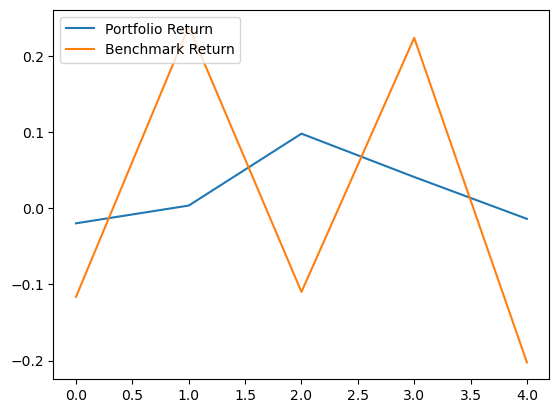

In [206]:
plot_returns(portfolio_returns, benchmark_returns)
#plot_returns(portfolio_sharpe, benchmark_sharpe, returns=False)

In [ ]:
test = get_pred_df_sharpe(df_train,
                          df_test,
                          model=model,
                          batch_size=batch_size,
                          lookback=lookback,
                          tickers=tickers,
                          test_only=True)
test.iloc[:, 13:-7].abs().sum(axis=1) # check sum of each column


In [236]:
print(total_return(df_predictions['return_benchmark']),
      sharpe_ratio(df_predictions['return_benchmark']),
      total_return(df_predictions['return_portfolio']),
      sharpe_ratio(df_predictions['return_portfolio']),
      total_return(df_predictions['total_portfolio_return']),
      sharpe_ratio(df_predictions['total_portfolio_return']))


-0.01003932372072247 -0.04560495907800849 0.018706764420702182 0.48128465883416843 -0.015378114008511412 -0.39567180725041023


In [ ]:
df_predictions['USO_port_weight'].min()